# 1. DEPENDENCIES AND SETUP

In [1]:
%%capture
!pip install torch torchvision
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
import os
import cv2
import json
import random
import numpy as np
from pathlib import Path
from zipfile import ZipFile
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor

# 2. GPU CHECK

In [3]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: Tesla T4


# 3. GOOGLE DRIVE MOUNT

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 4. DETECTRON2 IMPORTS

In [5]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


# 5. TRAINER CLASS DEFINITION

In [6]:
class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)


# 6. MODEL CONFIGURATION

In [7]:
def setup_cfg(train_json, val_json, num_classes, output_dir):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("id_card_train",)
    cfg.DATASETS.TEST = ("id_card_val",)
    cfg.DATALOADER.NUM_WORKERS = 2

    # Initialize weights with the pre-trained model but exclude the incompatible layers
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.MODEL.ROI_BOX_HEAD.CLS_AGNOSTIC_BBOX_REG = True  # Optional: If you want to use class-agnostic bounding box regression

    # Configure other training parameters
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 5000  # Increase to 10 000
    cfg.SOLVER.STEPS = (3000, 4000)  # Add learning rate decay steps
    cfg.SOLVER.GAMMA = 0.1  # Learning rate decay factor
    cfg.TEST.EVAL_PERIOD = 500  # Evaluate every 500 iterations
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.OUTPUT_DIR = output_dir

    return cfg

# 7. TRAINING MODEL SETUP

In [8]:
def train_model(train_json, val_json, train_images_dir, val_images_dir, output_dir, num_classes):
    print("Setting up datasets...")
    register_coco_instances(
        "id_card_train",
        {},
        train_json,
        train_images_dir
    )
    register_coco_instances(
        "id_card_val",
        {},
        val_json,
        val_images_dir
    )

    print("Configuring model...")
    cfg = setup_cfg(train_json, val_json, num_classes, output_dir)
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    print("Starting training...")
    trainer = CocoTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

# 8. DATASET PREPARATION

In [9]:
import os
from pathlib import Path

# Set up paths with the correct structure
GDRIVE_PATH = "/content/drive/MyDrive/Kwantu/Machine Learning/id_card_dataset"

print("Checking Google Drive mount...")
if not os.path.exists("/content/drive"):
    print("Google Drive is not mounted. Mounting now...")
    from google.colab import drive
    drive.mount('/content/drive')

print("\nVerifying source paths...")
# Check source paths
source_json = os.path.join(GDRIVE_PATH, "merged_coco.json")
source_images = os.path.join(GDRIVE_PATH, "images")

if not os.path.exists(source_json):
    raise FileNotFoundError(f"JSON file not found at: {source_json}")
else:
    print(f"✓ Found JSON file at: {source_json}")

if not os.path.exists(source_images):
    raise FileNotFoundError(f"Images directory not found at: {source_images}")
else:
    print(f"✓ Found images directory at: {source_images}")

print("\nCreating dataset directories...")
# Create dataset directories
os.makedirs("/content/dataset", exist_ok=True)
os.makedirs("/content/dataset/images", exist_ok=True)
print("✓ Created dataset directories")

print("\nCopying files...")
# Copy files
!cp "{source_json}" /content/dataset/
!cp -r "{source_images}/"* /content/dataset/images/


Checking Google Drive mount...

Verifying source paths...
✓ Found JSON file at: /content/drive/MyDrive/Kwantu/Machine Learning/id_card_dataset/merged_coco.json
✓ Found images directory at: /content/drive/MyDrive/Kwantu/Machine Learning/id_card_dataset/images

Creating dataset directories...
✓ Created dataset directories

Copying files...


# 9. VERIFICATION STEPS

In [10]:
# Quick verification before training
print("\nFinal verification before training:")
json_path = "/content/dataset/merged_coco.json"
images_dir = "/content/dataset/images"

# Check JSON file
if os.path.exists(json_path):
    with open(json_path, 'r') as f:
        try:
            coco_data = json.load(f)
            print(f"✓ JSON file is valid")
            print(f"  - Number of images in JSON: {len(coco_data['images'])}")
            print(f"  - Number of annotations: {len(coco_data['annotations'])}")
            print(f"  - Categories: {[cat['name'] for cat in coco_data['categories']]}")
        except json.JSONDecodeError:
            print("✗ Error: JSON file is not valid")
else:
    print("✗ Error: JSON file not found")

# Check images
if os.path.exists(images_dir):
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    print(f"\n✓ Found {len(image_files)} images in directory")

    # Verify a random image can be opened
    if image_files:
        test_image = os.path.join(images_dir, random.choice(image_files))
        img = cv2.imread(test_image)
        if img is not None:
            print(f"✓ Successfully loaded a test image")
        else:
            print("✗ Error: Could not load test image")
else:
    print("✗ Error: Images directory not found")


Final verification before training:
✓ JSON file is valid
  - Number of images in JSON: 625
  - Number of annotations: 663
  - Categories: ['New', 'Old']

✓ Found 459 images in directory
✓ Successfully loaded a test image



# 10. TRAINING SCRIPT CREATION




In [11]:
%%writefile /content/train_colab.py
import os
import json
import torch
import argparse
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.events import EventWriter
import time
from torch.utils.tensorboard import SummaryWriter

class ProgressTrainer(DefaultTrainer):
    def __init__(self, cfg):
        super().__init__(cfg)
        self.tb_writer = SummaryWriter(os.path.join(cfg.OUTPUT_DIR, "tensorboard"))

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)



def setup_cfg(train_json, val_json, num_classes, output_dir):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("id_card_train",)
    cfg.DATASETS.TEST = ("id_card_val",)

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 5000
    cfg.SOLVER.STEPS = []
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.OUTPUT_DIR = output_dir

    return cfg

def main():
    parser = argparse.ArgumentParser(description='Train Detectron2 model on ID card dataset')
    parser.add_argument('--train-json', required=True, help='Path to training JSON file')
    parser.add_argument('--val-json', required=True, help='Path to validation JSON file')
    parser.add_argument('--train-images-dir', required=True, help='Path to training images directory')
    parser.add_argument('--val-images-dir', required=True, help='Path to validation images directory')
    parser.add_argument('--output-dir', required=True, help='Path to output directory')
    parser.add_argument('--num-classes', type=int, required=True, help='Number of classes')
    args = parser.parse_args()

    print("Setting up datasets...")
    register_coco_instances(
        "id_card_train",
        {},
        args.train_json,
        args.train_images_dir
    )
    register_coco_instances(
        "id_card_val",
        {},
        args.val_json,
        args.val_images_dir
    )

    print("Configuring model...")
    cfg = setup_cfg(args.train_json, args.val_json, args.num_classes, args.output_dir)
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    print("Starting training...")
    trainer = ProgressTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

if __name__ == "__main__":
    main()

Writing /content/train_colab.py


# 11. TRAINING EXECUTION

In [ ]:
# Start TensorBoard
%load_ext tensorboard
%tensorboard --logdir /content/training_output/tensorboard

# Start training
!python train_colab.py \
    --train-json "/content/dataset/merged_coco_verified.json" \
    --val-json "/content/dataset/merged_coco_verified.json" \
    --train-images-dir "/content/dataset/images" \
    --val-images-dir "/content/dataset/images" \
    --output-dir "/content/training_output" \
    --num-classes 2

# 12. MODEL SAVING

In [68]:
# Save model to Drive
!mkdir -p "{GDRIVE_PATH}/trained_model"
!cp -r /content/training_output "{GDRIVE_PATH}/trained_model/"

# 13. DETECTRON2 REPOSITORY CLONE

In [12]:
!git clone https://github.com/facebookresearch/detectron2.git detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 15837 (delta 30), reused 12 (delta 12), pack-reused 15781 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 4.06 MiB/s, done.
Resolving deltas: 100% (11537/11537), done.


# 14. PREDICTOR SETUP

In [13]:
def setup_predictor():
    cfg = get_cfg()
    cfg.merge_from_file("/content/detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Only 2 classes: New and Old

    model_path = f"{GDRIVE_PATH}/trained_model/training_output/model_final.pth"

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at: {model_path}")

    cfg.MODEL.WEIGHTS = model_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
    cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

    return DefaultPredictor(cfg)

# 15. TESTING AND VISUALIZATION FUNCTIONS

/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))


Processing: 4b2b0d5f-6006040457088_A.jpeg


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


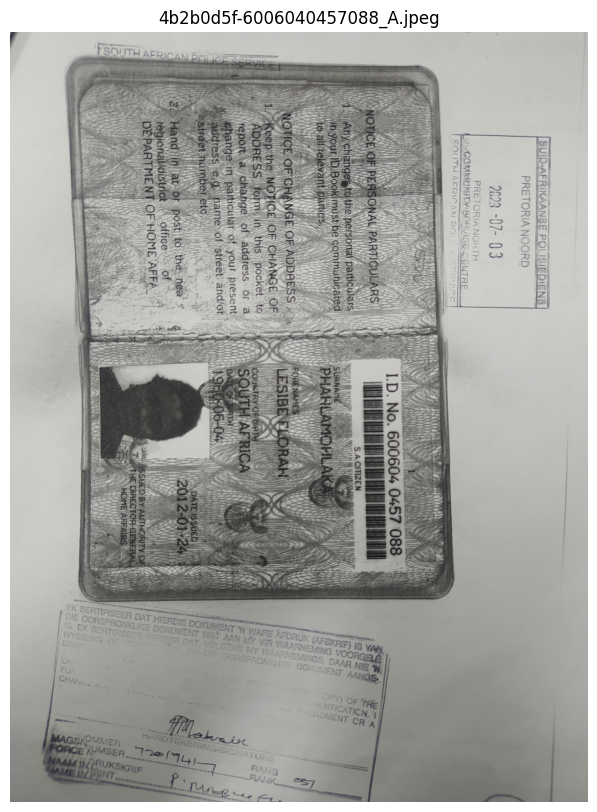


Processing: 7ff1eb5c-6201275878088_B.jpeg
Saved: detected_regions/7ff1eb5c-6201275878088_B/Old_0.75.jpg
Saved: detected_regions/7ff1eb5c-6201275878088_B/Old_0.73.jpg
Saved: detected_regions/7ff1eb5c-6201275878088_B/Old_0.70.jpg


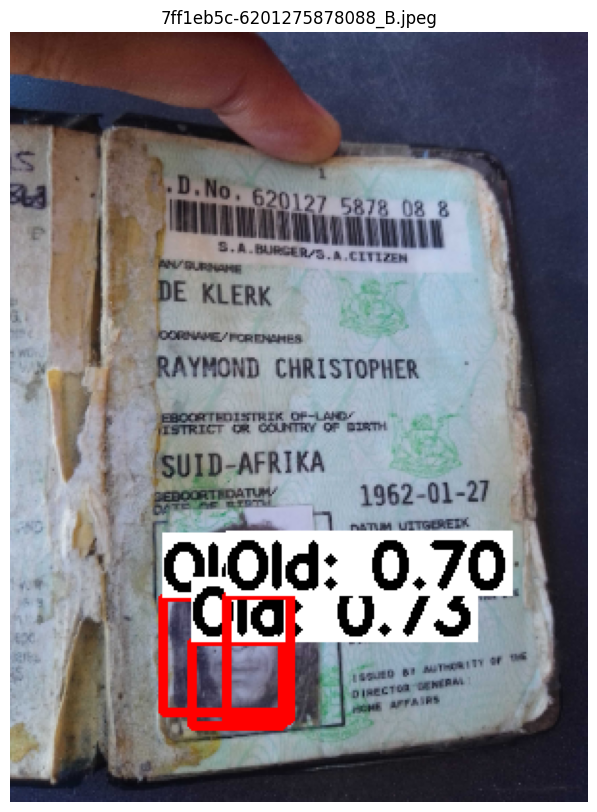


Processing: 594a6e0b-6207235208084_B.jpeg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.76.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.74.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.74.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.74.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.73.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.73.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.73.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.72.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.72.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.72.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.72.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.71.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.71.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.70.jpg
Saved: detected_regions/594a6e0b-6207235208084_B/Old_0.70.jpg


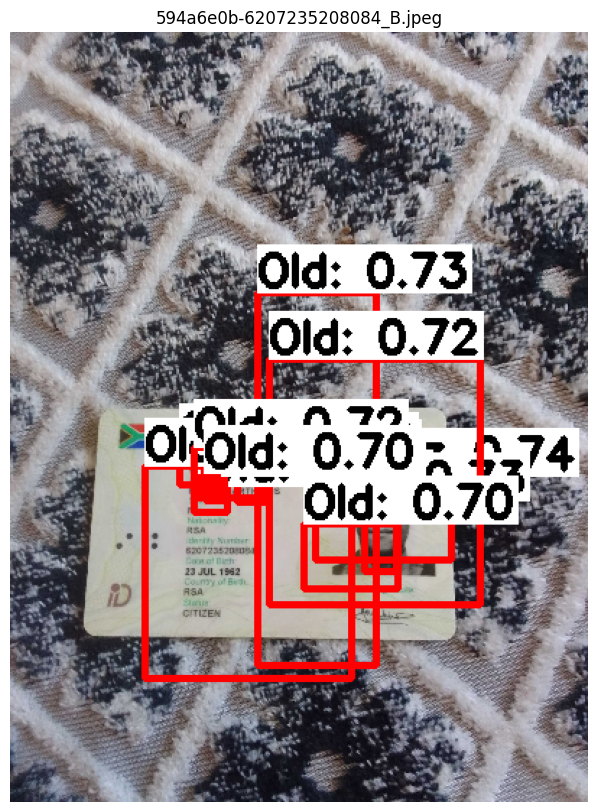


Processing: 5cf5ff84-0001017133081_B.jpeg
Saved: detected_regions/5cf5ff84-0001017133081_B/Old_0.84.jpg
Saved: detected_regions/5cf5ff84-0001017133081_B/Old_0.79.jpg
Saved: detected_regions/5cf5ff84-0001017133081_B/Old_0.78.jpg
Saved: detected_regions/5cf5ff84-0001017133081_B/Old_0.75.jpg
Saved: detected_regions/5cf5ff84-0001017133081_B/Old_0.74.jpg
Saved: detected_regions/5cf5ff84-0001017133081_B/Old_0.73.jpg
Saved: detected_regions/5cf5ff84-0001017133081_B/Old_0.72.jpg
Saved: detected_regions/5cf5ff84-0001017133081_B/Old_0.71.jpg


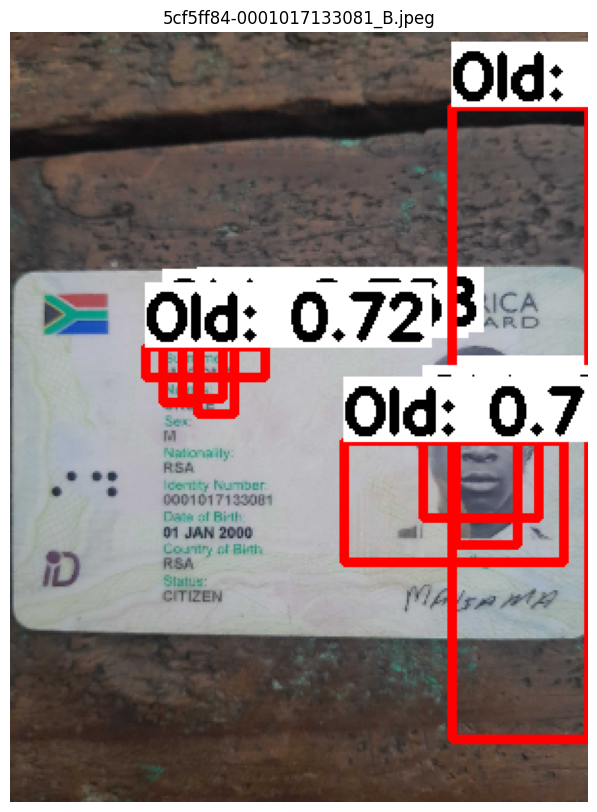


Processing: 0350bdd7-0001017815083_B.jpeg
Saved: detected_regions/0350bdd7-0001017815083_B/Old_0.79.jpg
Saved: detected_regions/0350bdd7-0001017815083_B/Old_0.76.jpg
Saved: detected_regions/0350bdd7-0001017815083_B/Old_0.76.jpg
Saved: detected_regions/0350bdd7-0001017815083_B/Old_0.75.jpg
Saved: detected_regions/0350bdd7-0001017815083_B/Old_0.73.jpg


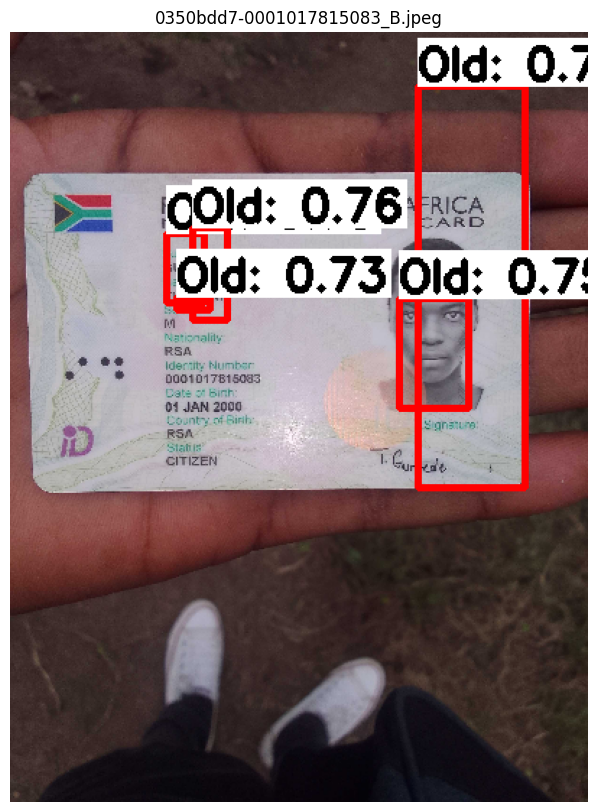


Processing: 3ad6bd84-6307100782088_B.jpeg
Saved: detected_regions/3ad6bd84-6307100782088_B/Old_0.71.jpg


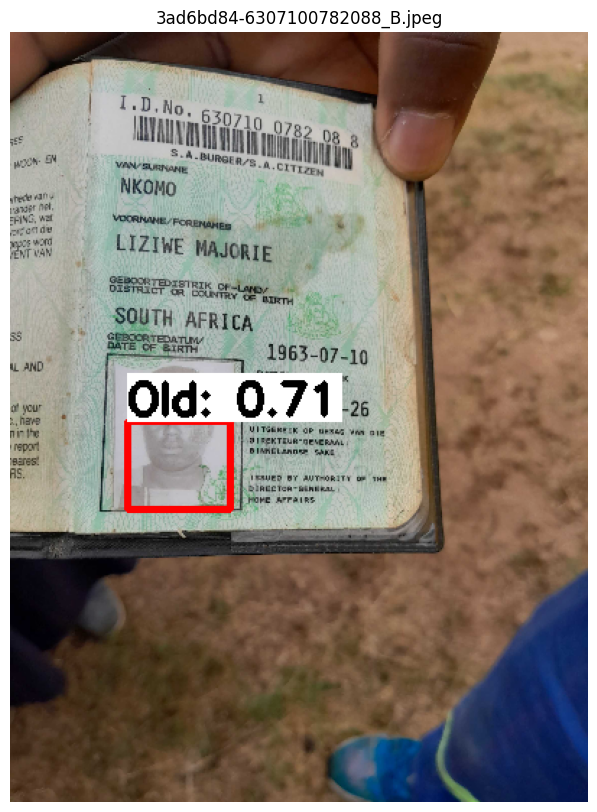


Processing: 22af90bd-6008015210088_A.jpeg
Saved: detected_regions/22af90bd-6008015210088_A/Old_0.73.jpg


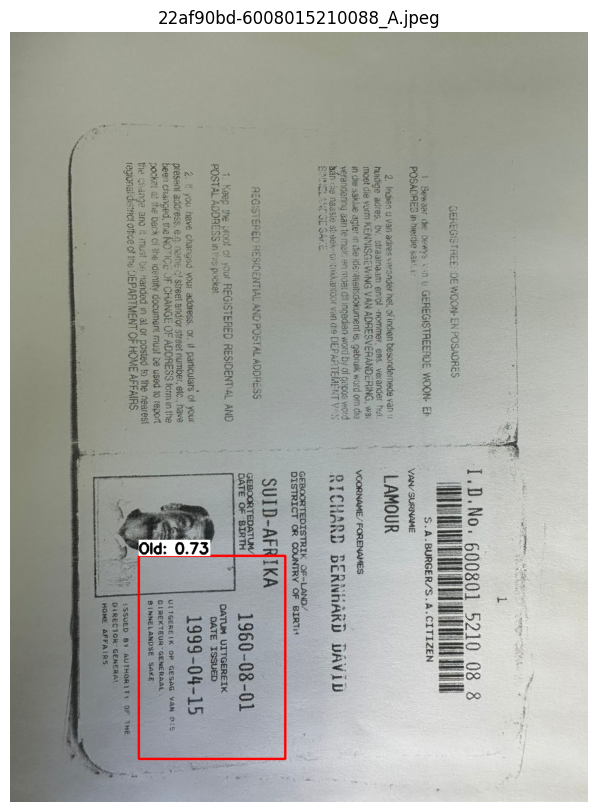


Processing: 3ecb6e43-0001020268080_B.jpeg
Saved: detected_regions/3ecb6e43-0001020268080_B/Old_0.81.jpg
Saved: detected_regions/3ecb6e43-0001020268080_B/Old_0.81.jpg
Saved: detected_regions/3ecb6e43-0001020268080_B/Old_0.78.jpg
Saved: detected_regions/3ecb6e43-0001020268080_B/Old_0.77.jpg
Saved: detected_regions/3ecb6e43-0001020268080_B/Old_0.77.jpg
Saved: detected_regions/3ecb6e43-0001020268080_B/Old_0.76.jpg
Saved: detected_regions/3ecb6e43-0001020268080_B/Old_0.75.jpg
Saved: detected_regions/3ecb6e43-0001020268080_B/Old_0.74.jpg
Saved: detected_regions/3ecb6e43-0001020268080_B/Old_0.73.jpg
Saved: detected_regions/3ecb6e43-0001020268080_B/Old_0.72.jpg
Saved: detected_regions/3ecb6e43-0001020268080_B/Old_0.72.jpg
Saved: detected_regions/3ecb6e43-0001020268080_B/Old_0.71.jpg


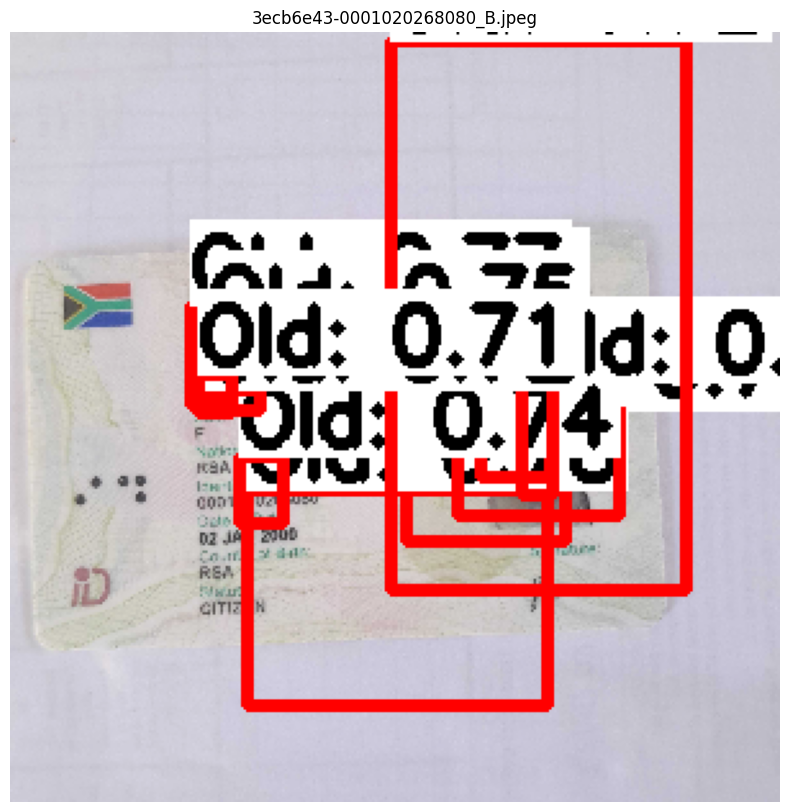


Processing: 365e8a11-0001025231083_A_B.jpg


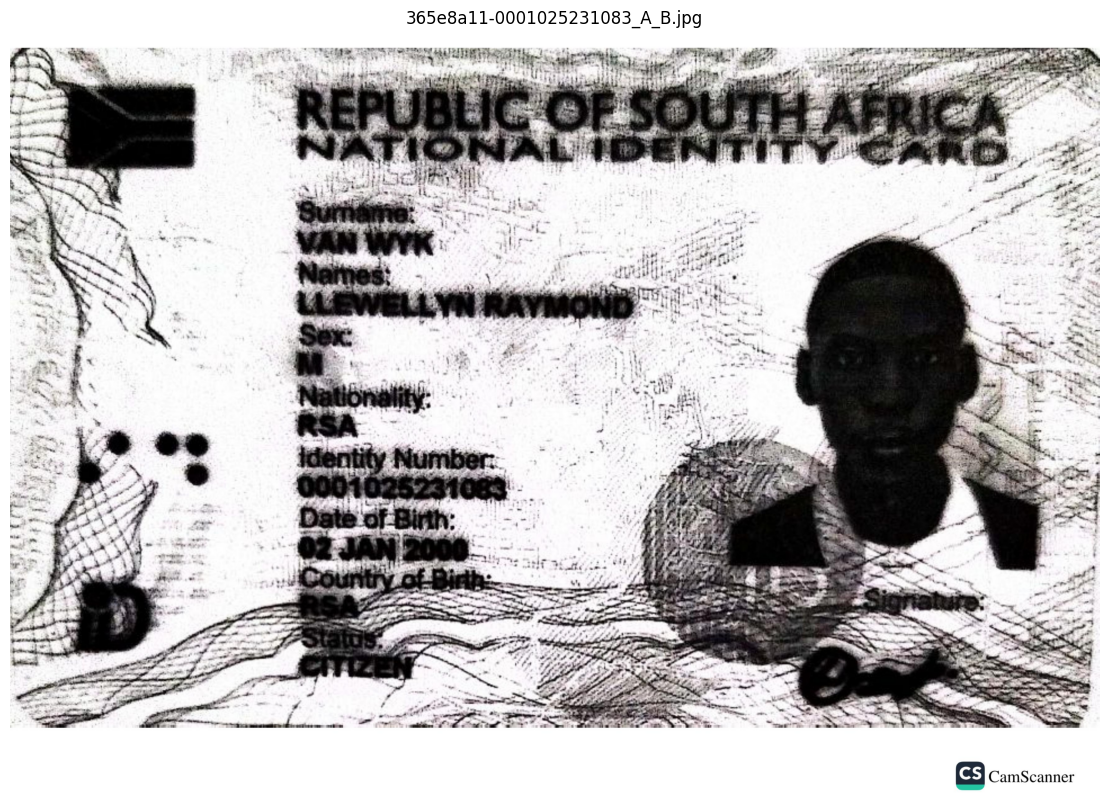


Processing: 7bce54d3-6002210166088_B.jpeg
Saved: detected_regions/7bce54d3-6002210166088_B/Old_0.74.jpg
Saved: detected_regions/7bce54d3-6002210166088_B/Old_0.73.jpg
Saved: detected_regions/7bce54d3-6002210166088_B/Old_0.73.jpg
Saved: detected_regions/7bce54d3-6002210166088_B/Old_0.73.jpg


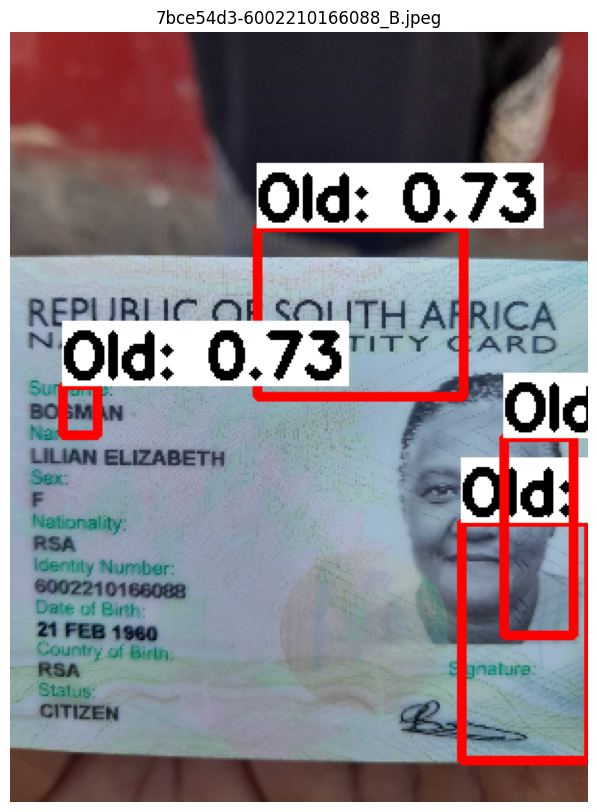


Processing: 3cc4b976-0001040619080_A_page_1.jpg
Saved: detected_regions/3cc4b976-0001040619080_A_page_1/Old_0.75.jpg
Saved: detected_regions/3cc4b976-0001040619080_A_page_1/Old_0.72.jpg
Saved: detected_regions/3cc4b976-0001040619080_A_page_1/Old_0.71.jpg


In [ ]:
def setup_predictor():
    cfg = get_cfg()
    # Use the config file from model_zoo instead of a local path
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Only 2 classes: New and Old

    # Update model path
    model_path = "/content/drive/MyDrive/Kwantu/Machine Learning/id_card_model/training_output/model_final.pth"  # Use local training output path

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at: {model_path}")

    cfg.MODEL.WEIGHTS = model_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
    cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

    return DefaultPredictor(cfg)
# Initialize predictor first
predictor = setup_predictor()

def save_segmented_regions(image_path, outputs, save_dir="detected_regions"):
    # Create output directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Rest of the function remains the same
    class_names = ["New", "Old"]
    colors = [(0,255,0), (255,0,0)]  # Green for New, Red for Old
    im = cv2.imread(image_path)
    if im is None:
        print(f"Error: Could not read image at {image_path}")
        return

    # Create main output directory with image name
    image_name = Path(image_path).stem
    base_save_dir = os.path.join(save_dir, image_name)
    os.makedirs(base_save_dir, exist_ok=True)

    # Get predictions
    boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    classes = outputs["instances"].pred_classes.cpu().numpy()
    scores = outputs["instances"].scores.cpu().numpy()

    # Save each detected region
    for idx, (box, class_id, score) in enumerate(zip(boxes, classes, scores)):
        x1, y1, x2, y2 = box.astype(int)
        region = im[y1:y2, x1:x2]
        if region.size == 0:
            continue

        class_name = class_names[class_id]
        filename = f"{class_name}_{score:.2f}.jpg"
        save_path = os.path.join(base_save_dir, filename)
        cv2.imwrite(save_path, region)
        print(f"Saved: {save_path}")

def visualize_and_save_prediction(image_path):
    # Read image
    print(f"\nProcessing: {Path(image_path).name}")
    im = cv2.imread(image_path)
    if im is None:
        print(f"Error: Could not read image at {image_path}")
        return

    # Make prediction
    outputs = predictor(im)

    # Save segmented regions
    save_segmented_regions(image_path, outputs)

    # Visualization code
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    class_names = ["New", "Old"]
    colors = [(0,255,0), (255,0,0)]

    # Get predictions
    boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    classes = outputs["instances"].pred_classes.cpu().numpy()
    scores = outputs["instances"].scores.cpu().numpy()

    # Draw predictions
    for box, class_id, score in zip(boxes, classes, scores):
        x1, y1, x2, y2 = box.astype(int)
        color = colors[class_id]

        # Draw box
        cv2.rectangle(im_rgb, (x1, y1), (x2, y2), color, 3)

        # Add label
        label = f"{class_names[class_id]}: {score:.2f}"
        font_scale = 1.0
        thickness = 3
        (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)

        # Draw label background
        cv2.rectangle(im_rgb, (x1, y1-label_h-10), (x1+label_w, y1), (255,255,255), -1)
        cv2.putText(im_rgb, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0,0,0), thickness)

    # Display result
    plt.figure(figsize=(15, 10))
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.title(Path(image_path).name)
    plt.show()
    plt.close()

def test_random_images(num_images=3):
    image_dir = "/content/dataset/images"
    images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]

    if not images:
        print("No images found in directory")
        return

    selected_images = random.sample(images, min(num_images, len(images)))

    for image_name in selected_images:
        image_path = os.path.join(image_dir, image_name)
        visualize_and_save_prediction(image_path)

def test_all_images():
    image_dir = "/content/dataset/images"
    images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]

    for image_name in images:
        image_path = os.path.join(image_dir, image_name)
        visualize_and_save_prediction(image_path)

# Test on all images
test_all_images()


# 16. OCR SETUP AND FUNCTIONS

In [ ]:
!apt install tesseract-ocr
!apt install libtesseract-dev
!pip install pytesseract==0.3.10

In [ ]:
import pytesseract
import cv2
import numpy as np
from PIL import Image
import re

def preprocess_image_for_ocr(img):
    """Apply various preprocessing techniques to improve OCR accuracy."""
    # Convert to grayscale if image is in color
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    # Denoise the image
    denoised = cv2.fastNlMeansDenoising(thresh)

    # Increase contrast
    contrast = cv2.convertScaleAbs(denoised, alpha=1.5, beta=0)

    return contrast

def extract_id_number(text):
    """Extract ID number using regex pattern matching."""
    # South African ID number pattern: YYMMDD SSSSC Z
    pattern = r'\b\d{13}\b'
    matches = re.findall(pattern, text.replace(" ", ""))
    return matches[0] if matches else None

def perform_enhanced_ocr(image_path, id_type="auto"):
    """
    Performs enhanced OCR on ID card images with preprocessing.

    Args:
        image_path: Path to the image file
        id_type: "new", "old", or "auto" (default) to determine specific processing

    Returns:
        dict: Dictionary containing extracted information
    """
    try:
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not read image at {image_path}")

        # Preprocess image
        processed_img = preprocess_image_for_ocr(img)

        # Convert to PIL Image
        pil_image = Image.fromarray(processed_img)

        # Perform OCR with specific configuration
        custom_config = r'--oem 3 --psm 6'
        text = pytesseract.image_to_string(pil_image, config=custom_config)

        # Extract information
        extracted_info = {
            'raw_text': text.strip(),
            'id_number': None,
            'confidence': None
        }

        # Try to extract ID number
        id_number = extract_id_number(text)
        if id_number:
            extracted_info['id_number'] = id_number

        # Get confidence scores
        confidence_data = pytesseract.image_to_data(pil_image, output_type=pytesseract.Output.DICT)
        if confidence_data['conf']:
            # Calculate average confidence excluding -1 values
            conf_values = [c for c in confidence_data['conf'] if c != -1]
            if conf_values:
                extracted_info['confidence'] = sum(conf_values) / len(conf_values)

        return extracted_info

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return {
            'raw_text': '',
            'id_number': None,
            'confidence': None,
            'error': str(e)
        }

def process_detected_regions(base_dir="detected_regions"):
    """
    Process all detected regions in the output directory.
    """
    results = []

    # Walk through all subdirectories in the detected_regions folder
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)

                # Determine ID type from filename
                id_type = "new" if "New" in file else "old" if "Old" in file else "auto"

                # Process image
                ocr_result = perform_enhanced_ocr(image_path, id_type)

                results.append({
                    'file': file,
                    'path': image_path,
                    'type': id_type,
                    'ocr_results': ocr_result
                })

    return results

# Function to display and save OCR results
def save_ocr_results(results, output_file="ocr_results.json"):
    """Save OCR results to a JSON file and display summary."""
    # Save detailed results to JSON
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)

    # Display summary
    print("\nOCR Processing Summary:")
    print("-" * 50)

    successful_extractions = sum(1 for r in results if r['ocr_results']['id_number'])
    total_images = len(results)

    print(f"Total images processed: {total_images}")
    print(f"Successful ID number extractions: {successful_extractions}")
    print(f"Success rate: {(successful_extractions/total_images)*100:.2f}%")
    print(f"\nDetailed results saved to: {output_file}")

In [ ]:
# After detection and saving regions
print("\nPerforming OCR on detected regions...")
ocr_results = process_detected_regions("/content/detected_regions")
save_ocr_results(ocr_results, "/content/ocr_results.json")

# 17. UTILITY FUNCTIONS

In [ ]:
def zip_folder(folder_path, output_filename):
  """Zips a folder and saves it locally.

  Args:
    folder_path: The path to the folder you want to zip.
    output_filename: The name of the output zip file.
  """
  with ZipFile(output_filename, 'w') as zipf:
    for root, _, files in os.walk(folder_path):
      for file in files:
        file_path = os.path.join(root, file)
        # Archive the file with its relative path within the folder
        zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Example usage
folder_to_zip = 'contents/detected_regions'
output_zip_file = 'detected_regions.zip'
zip_folder(folder_to_zip, output_zip_file)

print(f"Folder '{folder_to_zip}' zipped to '{output_zip_file}'")

# Others